In [1]:
# Wide style

# load the needed python and basf2 libraries
import glob, sys, math, time, os
from array import array
import numpy as np
import root_pandas
import pandas as pd
import scipy
from scipy.optimize import curve_fit 
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.size': 22})
print('hello world :)')
plt.style.use(['default'])

Welcome to JupyROOT 6.20/04
hello world :)


In [2]:
df = root_pandas.read_root('./MergedGammaVertexee500to1500MeV_1000per1000.root', key='tree')
print('file loaded')

'''
df = df.loc[df['svdTruePos'] > -80] 
df = df.loc[df['svdLayer'] == 3] 
df = df.loc[df['svdTrkPXDHits'] > 0] 
df = df.loc[df['svdTrkpT'] > 1]
print('selection applied')
'''

#df = df.assign(svdTrkAngle=(np.arctan(df.svdTrkPrime)*180/np.pi))

 
# show the saved variables
print(df.columns)

file loaded
Index(['__experiment__', '__run__', '__event__', '__candidate__',
       '__ncandidates__', '__weight__', 'px', 'py', 'pz', 'pt', 'p', 'E',
       'omega', 'firstSVDLayer', 'firstCDCLayer', 'firstPXDLayer', 'Mbc',
       'deltaE', 'dr', 'dphi', 'dcosTheta', 'x', 'y', 'z', 'distance',
       'isSignal', 'mcErrors', 'mcPDG', 'ep_px', 'ep_py', 'ep_pz', 'ep_pt',
       'ep_p', 'ep_E', 'ep_omega', 'ep_firstSVDLayer', 'ep_firstCDCLayer',
       'ep_firstPXDLayer', 'ep_isSignal', 'ep_mcErrors', 'ep_mcPDG', 'em_px',
       'em_py', 'em_pz', 'em_pt', 'em_p', 'em_E', 'em_omega',
       'em_firstSVDLayer', 'em_firstCDCLayer', 'em_firstPXDLayer',
       'em_isSignal', 'em_mcErrors', 'em_mcPDG'],
      dtype='object')


In [4]:
def single_histo(var, nbins, min, max, title, xtitle, color='red',stat=True, log=False):

    fig, ax = plt.subplots(figsize=(10, 8))

    n, bins, patches = plt.hist(var, range=(min, max), bins=nbins, alpha=0.5,facecolor=color, color=color, histtype='bar',density=True)

    plt.title(str(title), fontsize=20)
    plt.xlabel(str(xtitle), fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    if log==True:
        ax.set_yscale('log')
        
    mode = bins[n.argmax()]
    mean = var.mean()
    median = np.median(var)
    std = var.std()
    #quantile
    a = var.quantile(1-0.16) 
    b = var.quantile(0.16)
    q =(a-b)/2
    textstr = '\n'.join((
            r'$\mathrm{mean}=%.3f\ \mu$m' % (mean, ),
            r'$\mathrm{median}=%.3f\ \mu$m' % (median, ),
            r'$\mathrm{std}=%.2f\ \mu$m' % (std, ),
            r'$\mathrm{sigma68}=%.2f\ \mu$m' % (q, )))
    print(textstr)
    print('MPV = %.2f' % (mode,))
    
    if stat==True:
    # place a text box in upper left in axes coords
        props = dict(boxstyle='round', facecolor='snow', alpha=1)
        ax.text(0.58, 0.95, textstr, transform=ax.transAxes, fontsize=20, verticalalignment='top', bbox=props)

$\mathrm{mean}=0.393\ \mu$m
$\mathrm{median}=0.342\ \mu$m
$\mathrm{std}=0.26\ \mu$m
$\mathrm{sigma68}=0.27\ \mu$m
MPV = 0.10


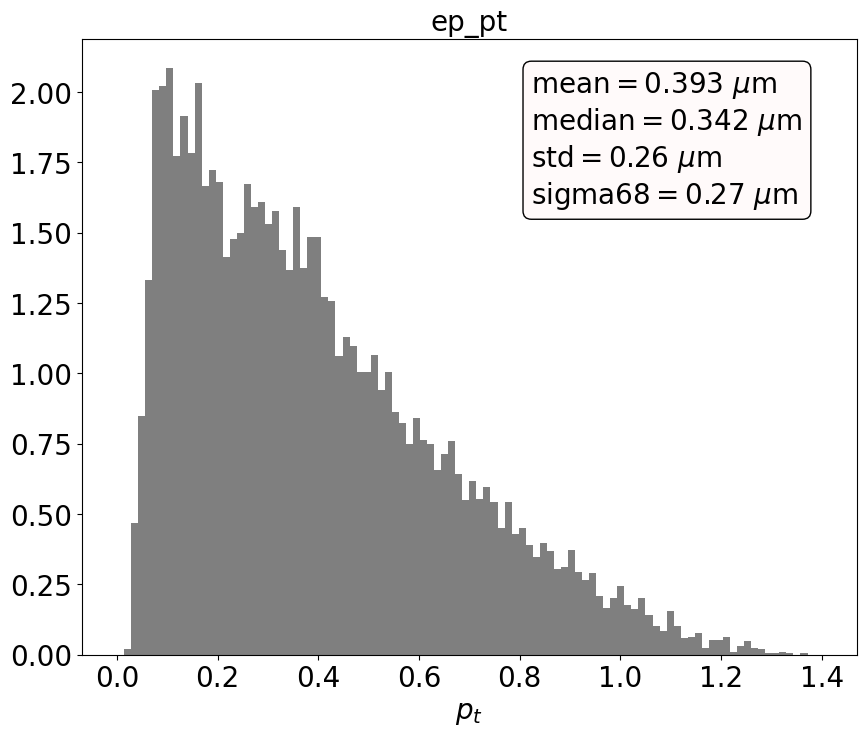

In [5]:
single_histo(df.ep_pt, 100, 0, 1.4, 'ep_pt', '$p_t$',color='black')

$\mathrm{mean}=0.040\ \mu$m
$\mathrm{median}=0.051\ \mu$m
$\mathrm{std}=9.80\ \mu$m
$\mathrm{sigma68}=6.10\ \mu$m


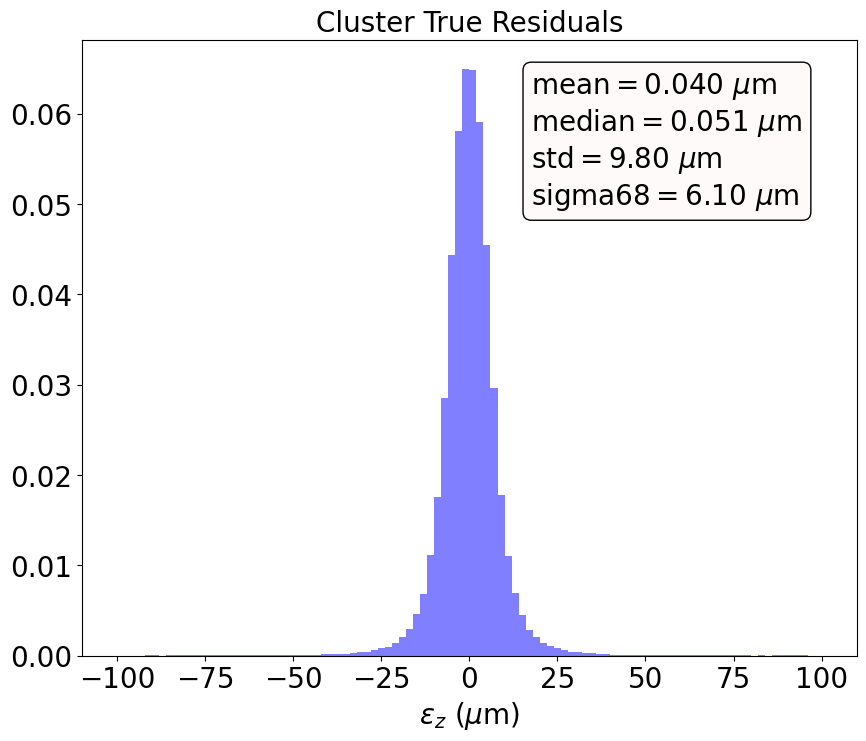

In [10]:
single_histo(df.trueClRes, 100, -100, 100, 'Cluster True Residuals', r'$\varepsilon_z\ (\mu$m)',color='blue')

$\mathrm{mean}=-0.250\ \mu$m
$\mathrm{median}=-0.230\ \mu$m
$\mathrm{std}=17.53\ \mu$m
$\mathrm{sigma68}=8.60\ \mu$m


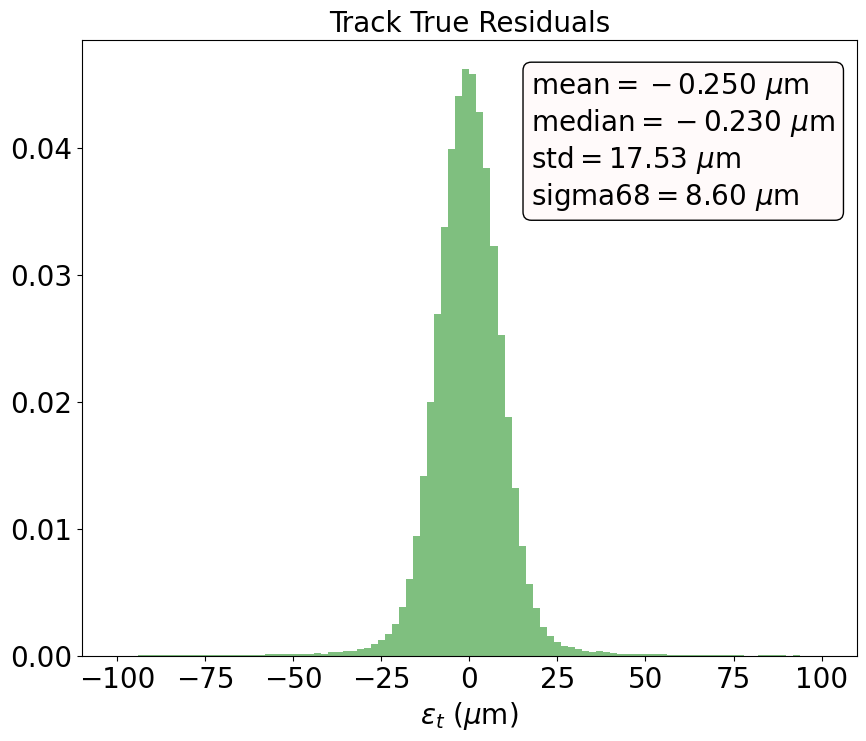

In [11]:
single_histo(df.trueTrkRes, 100, -100, 100, 'Track True Residuals', r'$\varepsilon_t\ (\mu$m)',color='green')

$\mathrm{mean}=7.047\ \mu$m
$\mathrm{median}=6.531\ \mu$m
$\mathrm{std}=3.73\ \mu$m
$\mathrm{sigma68}=1.45\ \mu$m
MPV = 5.00


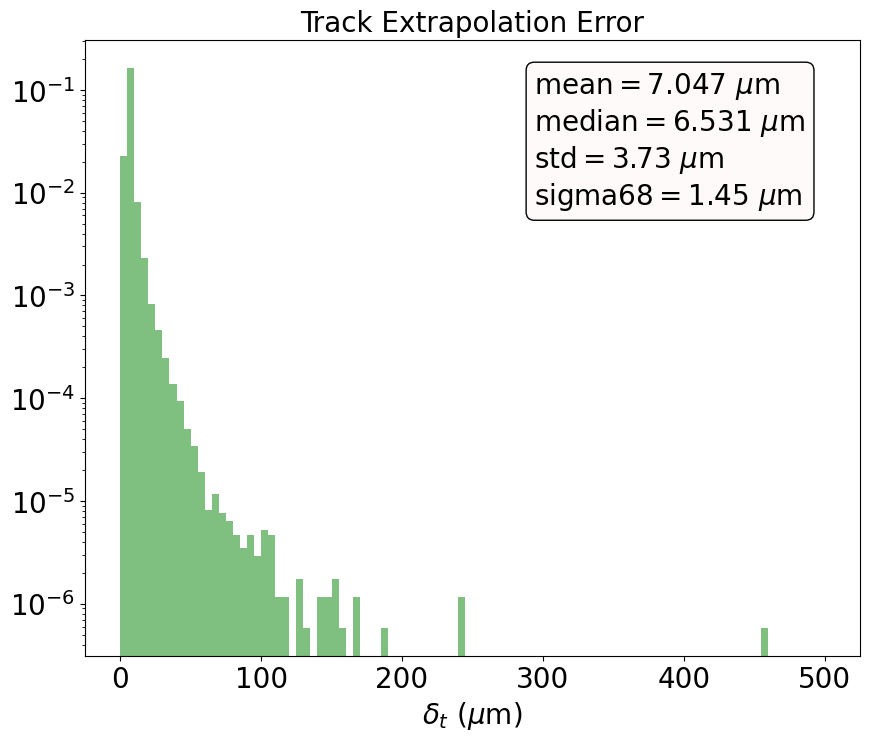

In [34]:
single_histo(df.svdTrkPosErrUnbiased, 100, 0, 500, 'Track Extrapolation Error', r'$\delta_t\ (\mu$m)',color='green',log=True)

(array([ 4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 7 Text major ticklabel objects>)

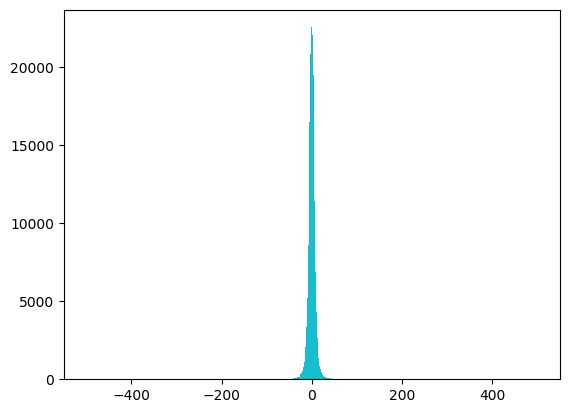

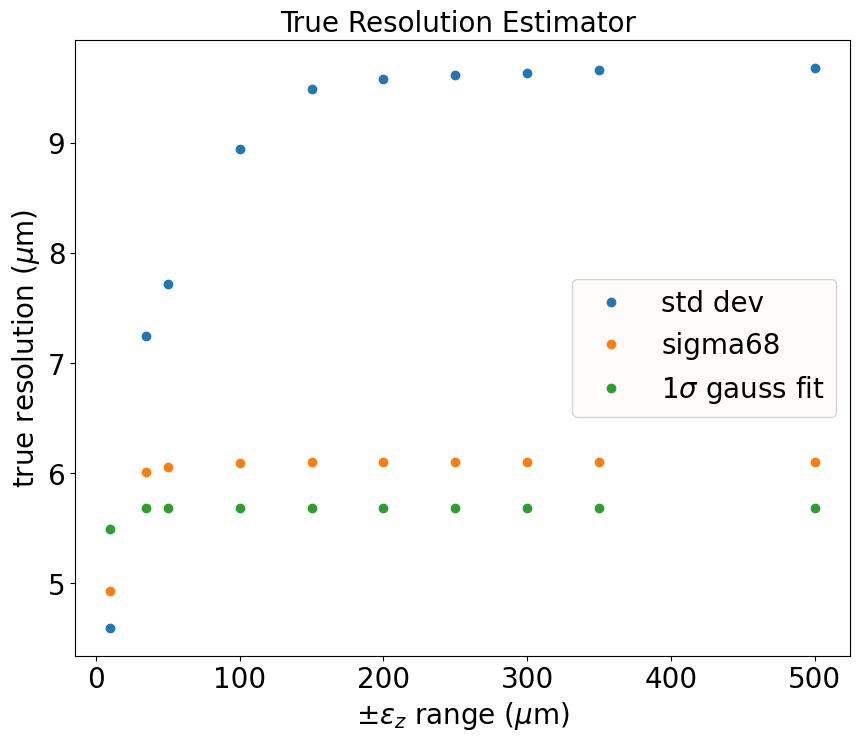

In [13]:
def gaussian(x, mu, sig, N):
    return N*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

x = np.array([10, 35, 50, 100, 150,200 ,250,300,350, 500])

n, bins, quant, std, fit = [], [], [], [], []

p0 =[0,10,100]

for c in x: 
    #quantile
    a = df['trueClRes'][abs(df['trueClRes']) < c].quantile(1-0.16) 
    b = df['trueClRes'][abs(df['trueClRes']) < c].quantile(0.16)
    q =(a-b)/2
    quant.append(q)
    #std dev
    s = df['trueClRes'][abs(df['trueClRes']) < c].std() 
    std.append(s)
    #1-sigma fit
    nbins = int(2*c)
    tmp_n, tmp_bins, patch = plt.hist(df['trueClRes'][abs(df['trueClRes']) < c],range=(-c,c), bins=nbins, density=False)
    popt, pcov = scipy.optimize.curve_fit(gaussian, np.resize(np.array(tmp_bins),len(tmp_bins)-1), np.array(tmp_n), p0=np.array(p0))
    fit.append(popt[1])
                           
fig, ax = plt.subplots(figsize=(10, 8))

plt.plot(x, std, 'o', label='std dev')   
plt.plot(x, quant, 'o', label='sigma68')                                           
plt.plot(x, fit, 'o', label=r'$1\sigma$ gauss fit')
plt.legend(fontsize=20, loc='center right',facecolor='snow')

plt.title(str("True Resolution Estimator "), fontsize=20)
plt.ylabel(str('true resolution $(\mu$m)'), fontsize=20)
plt.xlabel(r'$\pm \varepsilon_z$ range ($\mu$m)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
        1.e+06]),
 <a list of 9 Text major ticklabel objects>)

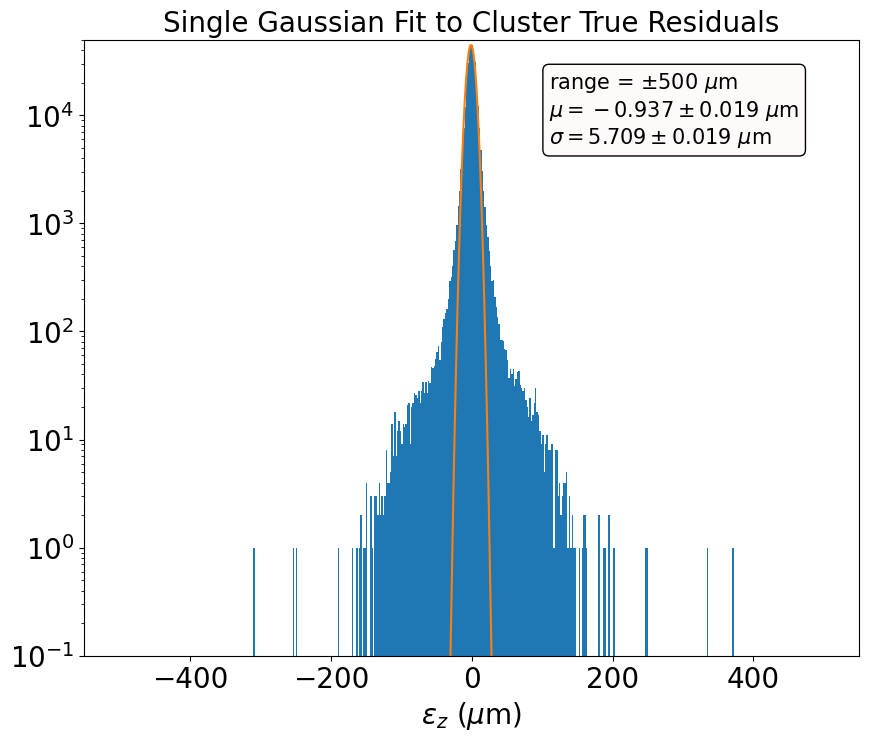

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))

p0=[0,10,10]

nbins = int(500)
tmp_n, tmp_bins, patch = plt.hist(df['trueClRes'][abs(df['trueClRes']) < nbins],range=(-nbins,nbins), bins=nbins, density=False, log=True)
popt, pcov = scipy.optimize.curve_fit(gaussian, np.resize(np.array(tmp_bins),len(tmp_bins)-1), np.array(tmp_n), p0=np.array(p0))
plt.plot(tmp_bins, gaussian(tmp_bins,popt[0],popt[1],popt[2]))
ax.set_ylim(0.1,50000)

textstr = '\n'.join((
            r'range = $\pm %.0f\ \mu$m' % (nbins, ),
            r'$\mu= %.3f \pm %.3f\ \mu$m' % (popt[0], np.sqrt(pcov[0][0]) ),
            r'$\sigma= %.3f \pm %.3f\ \mu$m' % (popt[1], np.sqrt(pcov[1][1]), )))
props = dict(boxstyle='round', facecolor='snow', alpha=1)
plt.text(0.6, 0.95, textstr, transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)
plt.title("Single Gaussian Fit to Cluster True Residuals", fontsize=20)
plt.xlabel(r'$\varepsilon_z\ (\mu$m)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

$\mathrm{mean}=13.406\ \mu$m
$\mathrm{median}=0.675\ \mu$m
$\mathrm{std}=720.85\ \mu$m
$\mathrm{sigma68}=37.38\ \mu$m


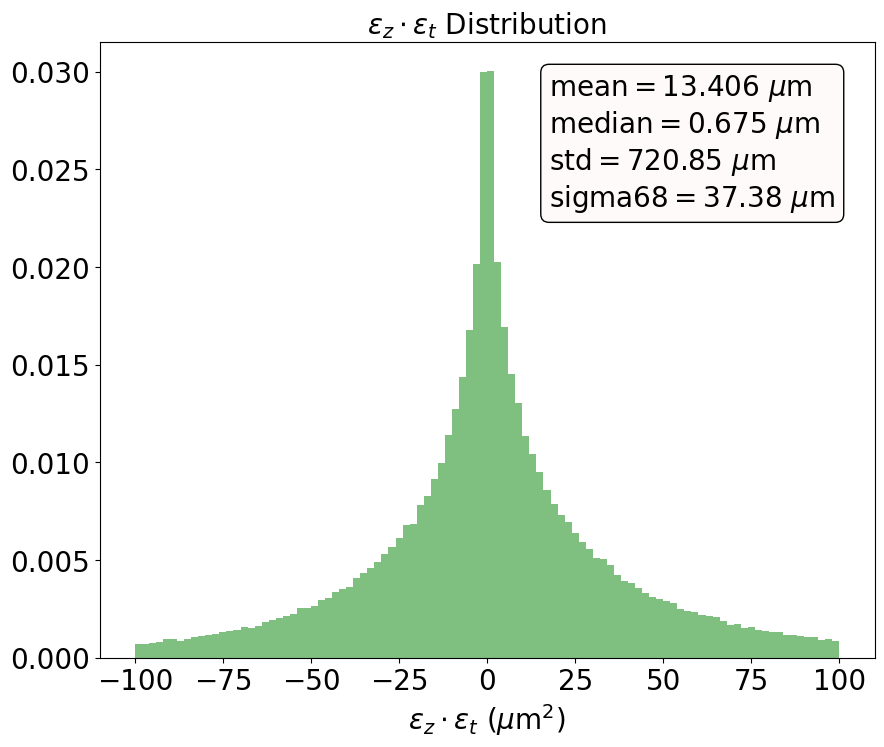

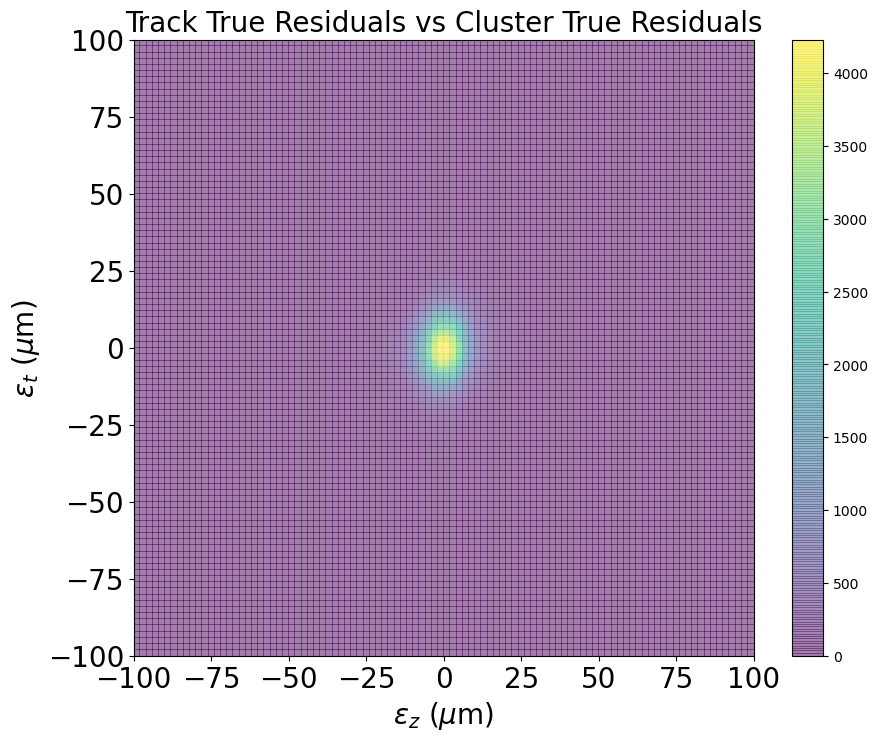

In [15]:
single_histo(df.svdClTrkPosCorr, 100, -100, 100, r'$\varepsilon_z\cdot\varepsilon_t$ Distribution', r'$\varepsilon_z\cdot\varepsilon_t\ (\mu$m$^2$)',color='green')

fig, ax = plt.subplots(figsize=(10, 8))

histo = plt.hist2d(df.trueClRes, df.trueTrkRes, range=[(-100,100),(-100,100)], bins=[100,100], density=False, alpha = 0.5)

plt.title('Track True Residuals vs Cluster True Residuals', fontsize=20)
plt.xlabel( r'$\varepsilon_z\ (\mu$m)', fontsize=20)
plt.ylabel( r'$\varepsilon_t\ (\mu$m)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.colorbar(histo[3], ax=ax)

$\mathrm{mean}=-0.048\ \mu$m
$\mathrm{median}=-0.035\ \mu$m
$\mathrm{std}=1.93\ \mu$m
$\mathrm{sigma68}=1.30\ \mu$m


Text(0.72, 0.95, '$\\mathrm{mean}=-0.048$\n$\\mathrm{median}=-0.035$\n$\\mathrm{std}=1.931$\n$\\mathrm{sigma68}=1.296$')

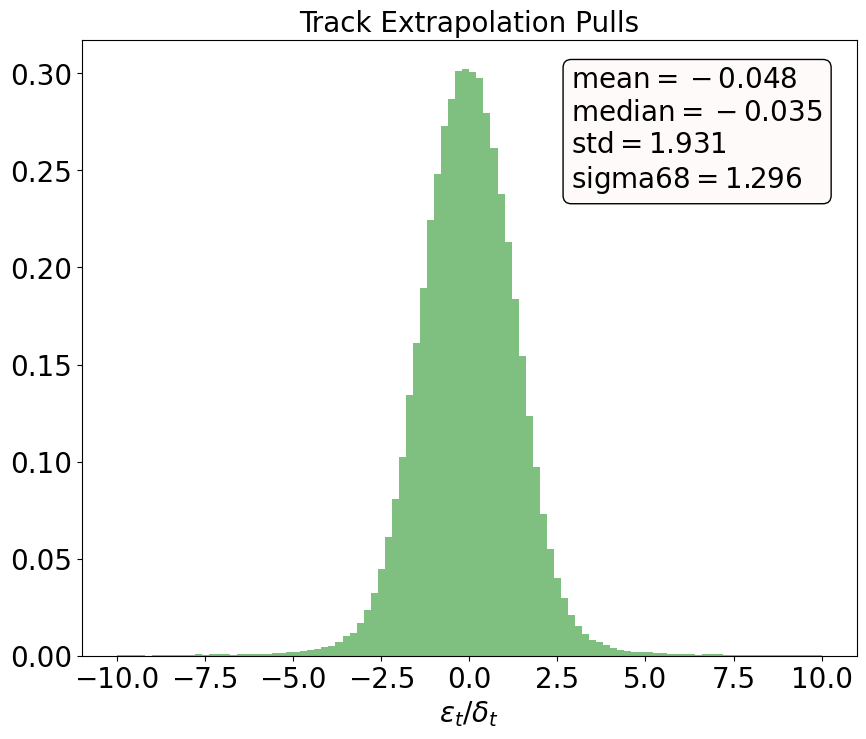

In [16]:
single_histo(df.trkPull, 100, -10, 10, 'Track Extrapolation Pulls', r'$\varepsilon_t/\delta_t$',color='green',stat=False)

mean = df.trkPull.mean()
median = np.median(df.trkPull)
std = df.trkPull.std()
a = df.trkPull.quantile(1-0.16) 
b = df.trkPull.quantile(0.16)
q =(a-b)/2
    
textstr = '\n'.join((
             r'$\mathrm{mean}=%.3f$' % (mean, ),
             r'$\mathrm{median}=%.3f$' % (median, ),
             r'$\mathrm{std}=%.3f$' % (std, ),
             r'$\mathrm{sigma68}=%.3f$' % (q, )))
props = dict(boxstyle='round', facecolor='snow')
plt.text(0.72, 0.95, textstr, transform=ax.transAxes, fontsize=20, verticalalignment='top', bbox=props)



m = 1.13 pm 0.03
q = 1.19 pm 0.43
m = -8.69 pm 0.92
q = 35.34 pm 1.97


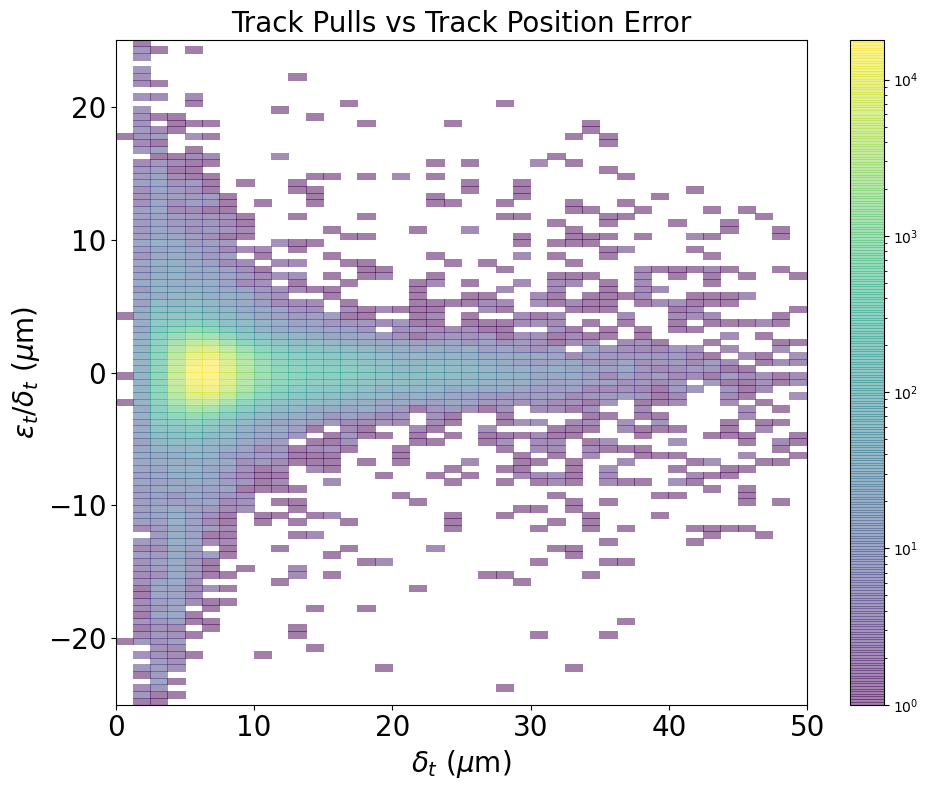

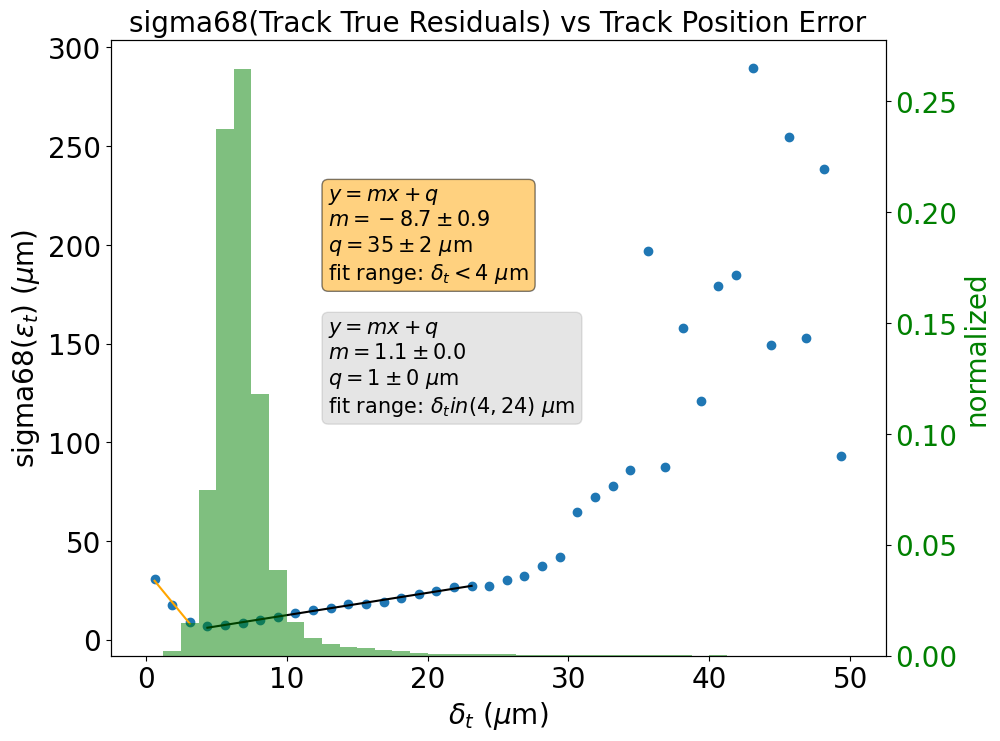

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))

from matplotlib.colors import LogNorm

#histo, xe, ye, im = plt.hist2d(df.svdTrkPosErrUnbiased, df.trueTrkRes, range=[(0,50),(-100,100)], bins=[40,100], density=False, alpha = 0.5, norm=LogNorm())
histo, xe, ye, im = plt.hist2d(df.svdTrkPosErrUnbiased, df.trkPull, range=[(0,50),(-25,25)], bins=[40,100], density=False, alpha = 0.5, norm=LogNorm())

#plt.title('Track Position Error vs True Residuals', fontsize=20)
plt.title('Track Pulls vs Track Position Error', fontsize=20)
plt.xlabel( r'$\delta_t\ (\mu$m)', fontsize=20)
#plt.ylabel( r'$\varepsilon_t\ (\mu$m)', fontsize=20)
plt.ylabel( r'$\varepsilon_t/\delta_t\ (\mu$m)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# bin width
xbinw = xe[1]-xe[0]

# getting the mean and RMS values of each vertical slice of the 2D distribution
x_slice_mean, x_slice_rms, x_slice_sigmaSE, x = [], [], [], []
for i,b in enumerate(xe[:-1]):
    mean = df['trueTrkRes'][ (df['svdTrkPosErrUnbiased']>xe[i]) & (df['svdTrkPosErrUnbiased']<=xe[i+1]) ].mean()
    std = df['trueTrkRes'][ (df['svdTrkPosErrUnbiased']>xe[i]) & (df['svdTrkPosErrUnbiased']<=xe[i+1]) ].std()
    a = df['trueTrkRes'][ (df['svdTrkPosErrUnbiased']>xe[i]) & (df['svdTrkPosErrUnbiased']<=xe[i+1]) ].quantile(1-0.16) 
    b = df['trueTrkRes'][ (df['svdTrkPosErrUnbiased']>xe[i]) & (df['svdTrkPosErrUnbiased']<=xe[i+1]) ].quantile(0.16) 
    x_slice_mean.append( mean )
    x_slice_rms.append( std )
    x_slice_sigmaSE.append((a-b)/2)
    x.append( (xe[i+1] + xe[i]) /2)
    
x_slice_mean = np.array(x_slice_mean)
x_slice_rms = np.array(x_slice_rms)
x_slice_sigmaSE = np.array(x_slice_sigmaSE)
x = np.array(x)
    
#plt.errorbar(xe[:-1]+ xbinw/2, x_slice_mean, x_slice_rms,fmt='_', ecolor='k', color='k')

plt.colorbar()

fig2, ax2 = plt.subplots(figsize=(10, 8))
plt.plot(x, x_slice_sigmaSE , 'o')
plt.title('sigma68(Track True Residuals) vs Track Position Error', fontsize=20)
plt.xlabel( r'$\delta_t\ (\mu$m)', fontsize=20)
plt.ylabel( r'sigma68($\varepsilon_t)\ (\mu$m)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

def pol1(x, a, b):
    return a*x+b

x2 = x[abs(x-14)<10]
y2 = x_slice_sigmaSE[abs(x-14)<10]
p0=[1,0]
popt, pcov = scipy.optimize.curve_fit(pol1, x2, y2, p0=np.array(p0))
plt.plot(x2, pol1(x2, popt[0],popt[1]),color='black')
print('m = %1.2f pm %1.2f' % (popt[0], np.sqrt(pcov[0][0])))
print('q = %1.2f pm %1.2f' % (popt[1], np.sqrt(pcov[1][1])))
textstr = '\n'.join((
            r'$y = mx +q$',
            r'$m =  %.1f \pm %.1f$' % (popt[0], np.sqrt(pcov[0][0]) ),
            r'$q= %.0f \pm %.0f\ \mu$m' % (popt[1], np.sqrt(pcov[1][1]), ),
            r'fit range: $\delta_t in (4,24)\ \mu$m'))
props = dict(boxstyle='round', facecolor='black', alpha=0.1)

x3 = x[x<4]
y3 = x_slice_sigmaSE[x<4]
p03=[1,0]
popt3, pcov3 = scipy.optimize.curve_fit(pol1, x3, y3, p0=np.array(p03))
plt.plot(x3, pol1(x3, popt3[0],popt3[1]), color='orange')
print('m = %1.2f pm %1.2f' % (popt3[0], np.sqrt(pcov3[0][0])))
print('q = %1.2f pm %1.2f' % (popt3[1], np.sqrt(pcov3[1][1])))
textstr3 = '\n'.join((
            r'$y = mx +q$',
            r'$m =  %.1f \pm %.1f$' % (popt3[0], np.sqrt(pcov3[0][0]) ),
            r'$q= %.0f \pm %.0f\ \mu$m' % (popt3[1], np.sqrt(pcov3[1][1]), ),
            r'fit range: $\delta_t < 4\ \mu$m'))
props3 = dict(boxstyle='round', facecolor='orange', alpha=0.5)


ax3 = ax2.twinx()  # instantiate a second axes that shares the same x-axis

ax3.set_ylabel('normalized', color='green', fontsize=20) 
histo = plt.hist(df.svdTrkPosErrUnbiased, range=(0, 50), bins=40, alpha=0.5,facecolor='green', color='green', histtype='bar',density=True)
ax3.tick_params(axis='y', labelcolor='green',labelsize=20)

fig.tight_layout()  # otherwise the right y-label is slightly clipped


ax3.text(0.3, 0.5, textstr, transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)
ax3.text(0.3, 0.7, textstr3, transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props3)

plt.show()

$\mathrm{mean}=313.177\ \mu$m
$\mathrm{median}=6.514\ \mu$m
$\mathrm{std}=8656.39\ \mu$m
$\mathrm{sigma68}=112.67\ \mu$m


Text(0.55, 0.9, '$\\mathrm{mean}=313.177\\ \\mu$m$^2$\n$\\mathrm{median}=6.514\\ \\mu$m$^2$\n$\\mathrm{std}=8656.392\\ \\mu$m$^2$\n$\\mathrm{sigma68}=112.673\\ \\mu$m$^2$')

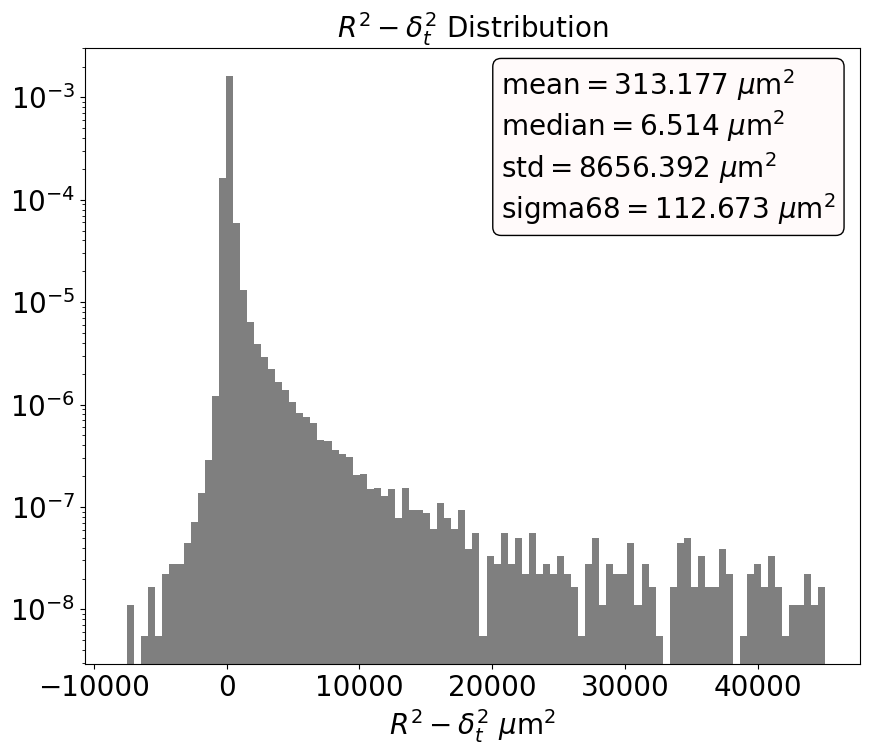

In [18]:
single_histo(df.svdRi2, 100, -8000, 45000, r'$R^2 - \delta_t^2$ Distribution', r'$R^2 - \delta_t^2\ \mu$m$^2$',color='black', stat=False,log=True)

mean = df.svdRi2.mean()
median = np.median(df.svdRi2)
std = df.svdRi2.std()
a = df.svdRi2.quantile(1-0.16) 
b = df.svdRi2.quantile(0.16)
q =(a-b)/2
    
textstr = '\n'.join((
             r'$\mathrm{mean}=%.3f\ \mu$m$^2$' % (mean, ),
             r'$\mathrm{median}=%.3f\ \mu$m$^2$' % (median, ),
             r'$\mathrm{std}=%.3f\ \mu$m$^2$' % (std, ),
             r'$\mathrm{sigma68}=%.3f\ \mu$m$^2$' % (q, )))
props = dict(boxstyle='round', facecolor='snow')
plt.text(0.55, 0.9, textstr, transform=ax.transAxes, fontsize=20, verticalalignment='top', bbox=props)

$\mathrm{mean}=69.326\ \mu$m
$\mathrm{median}=8.825\ \mu$m
$\mathrm{std}=1725.20\ \mu$m
$\mathrm{sigma68}=81.47\ \mu$m


Text(0.55, 0.9, '$\\mathrm{mean}=69.326\\ \\mu$m$^2$\n$\\mathrm{median}=6.514\\ \\mu$m$^2$\n$\\mathrm{std}=1725.197\\ \\mu$m$^2$\n$\\mathrm{sigma68}=81.469\\ \\mu$m$^2$')

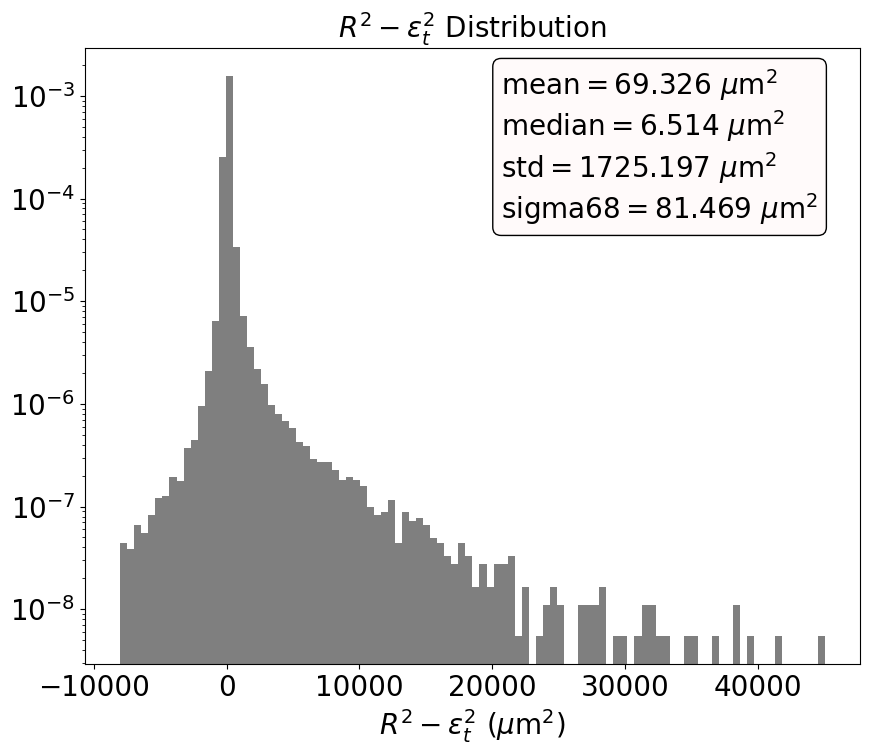

In [19]:
single_histo(df.svdRi2tt, 100, -8000, 45000, r'$R^2 - \varepsilon_t^2$ Distribution', r'$R^2 - \varepsilon_t^2\ (\mu$m$^2)$',color='black', stat=False,log=True)


mean = df.svdRi2tt.mean()
median = np.median(df.svdRi2)
std = df.svdRi2tt.std()
a = df.svdRi2tt.quantile(1-0.16) 
b = df.svdRi2tt.quantile(0.16)
q =(a-b)/2
    
textstr = '\n'.join((
             r'$\mathrm{mean}=%.3f\ \mu$m$^2$' % (mean, ),
             r'$\mathrm{median}=%.3f\ \mu$m$^2$' % (median, ),
             r'$\mathrm{std}=%.3f\ \mu$m$^2$' % (std, ),
             r'$\mathrm{sigma68}=%.3f\ \mu$m$^2$' % (q, )))
props = dict(boxstyle='round', facecolor='snow')
plt.text(0.55, 0.9, textstr, transform=ax.transAxes, fontsize=20, verticalalignment='top', bbox=props)

$\mathrm{mean}=0.112\ \mu$m
$\mathrm{median}=0.015\ \mu$m
$\mathrm{std}=10.78\ \mu$m
$\mathrm{sigma68}=0.86\ \mu$m


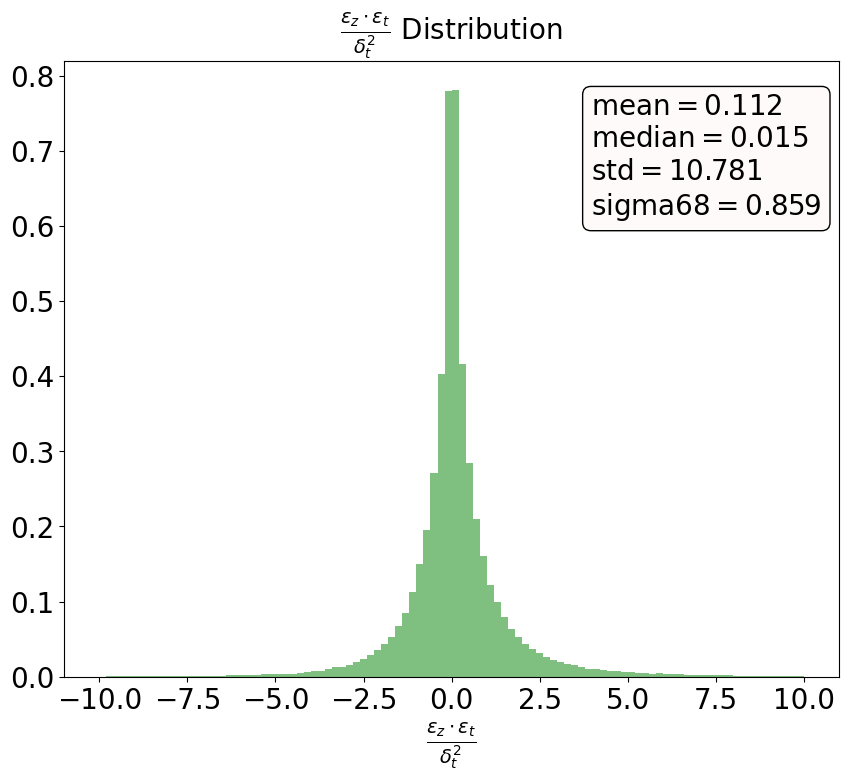

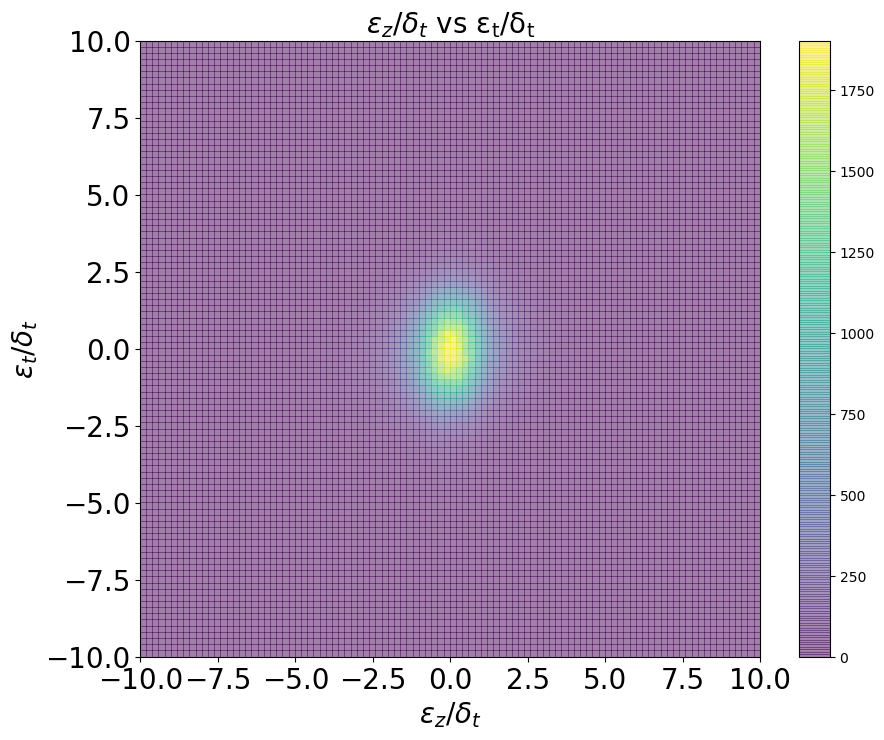

In [20]:
single_histo(df.svdClTrkCorrFrac2, 100, -10, 10, r'$\frac{\varepsilon_z\cdot\varepsilon_t}{\delta_t^2}$ Distribution', r'$\frac{\varepsilon_z\cdot\varepsilon_t}{\delta_t^2}$',color='green',stat=False)

mean = df.svdClTrkCorrFrac2.mean()
median = np.median(df.svdClTrkCorrFrac2)
std = df.svdClTrkCorrFrac2.std()
a = df.svdClTrkCorrFrac2.quantile(1-0.16) 
b = df.svdClTrkCorrFrac2.quantile(0.16)
q =(a-b)/2
    
textstr = '\n'.join((
             r'$\mathrm{mean}=%.3f$' % (mean, ),
             r'$\mathrm{median}=%.3f$' % (median, ),
             r'$\mathrm{std}=%.3f$' % (std, ),
             r'$\mathrm{sigma68}=%.3f$' % (q, )))
props = dict(boxstyle='round', facecolor='snow')
plt.text(0.68, 0.9, textstr, transform=ax.transAxes, fontsize=20, verticalalignment='top', bbox=props)

fig, ax = plt.subplots(figsize=(10, 8))

histo = plt.hist2d(df.trueClResFrac, df.trkPull, range=[(-10,10),(-10,10)], bins=[100,100], density=False, alpha = 0.5)

plt.title( r'$\varepsilon_z/\delta_t\ \rm{vs}\ \varepsilon_t/\delta_t$', fontsize=20)
plt.xlabel( r'$\varepsilon_z/\delta_t$', fontsize=20)
plt.ylabel( r'$\varepsilon_t/\delta_t$', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.colorbar(histo[3], ax=ax)

$\mathrm{mean}=1.533\ \mu$m
$\mathrm{median}=0.381\ \mu$m
$\mathrm{std}=10.73\ \mu$m
$\mathrm{sigma68}=1.04\ \mu$m
MPV = 0.00
$\mathrm{mean}=96.139\ \mu$m
$\mathrm{median}=16.495\ \mu$m
$\mathrm{std}=1086.20\ \mu$m
$\mathrm{sigma68}=42.71\ \mu$m
MPV = 0.00
$\mathrm{mean}=0.027\ \mu$m
$\mathrm{median}=0.023\ \mu$m
$\mathrm{std}=0.02\ \mu$m
$\mathrm{sigma68}=0.01\ \mu$m
MPV = 0.02


Text(0.45, 0.95, '$\\mathrm{mean}=0.027\\ \\mu$m$^{-2}$\n$\\mathrm{median}=0.023\\ \\mu$m$^{-2}$\n$\\mathrm{std}=0.019\\ \\mu$m$^{-2}$\n$\\mathrm{sigma68}=0.011\\ \\mu$m$^{-2}$')

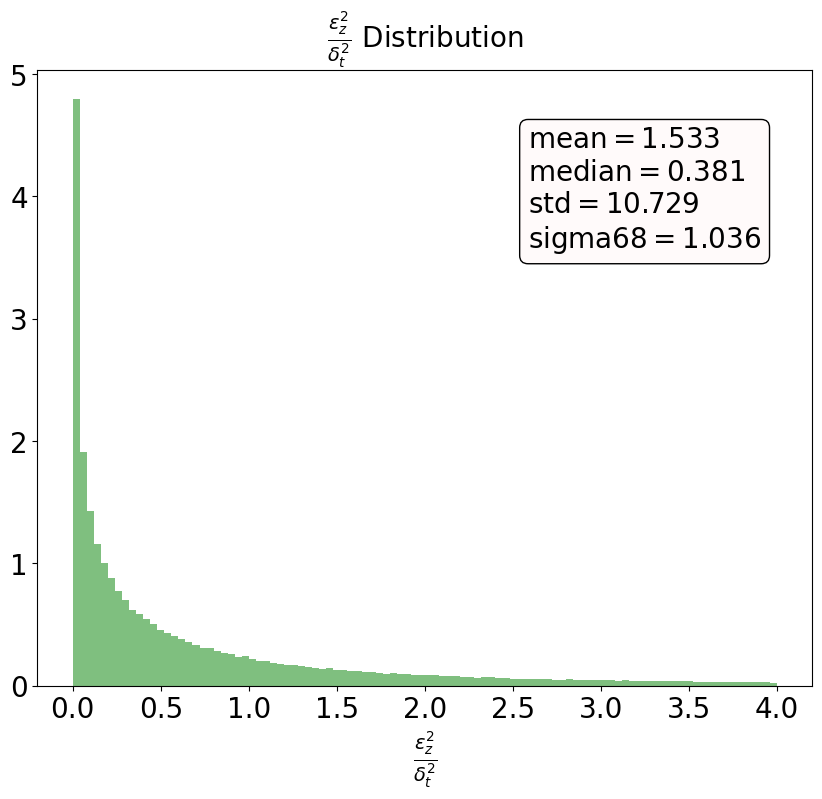

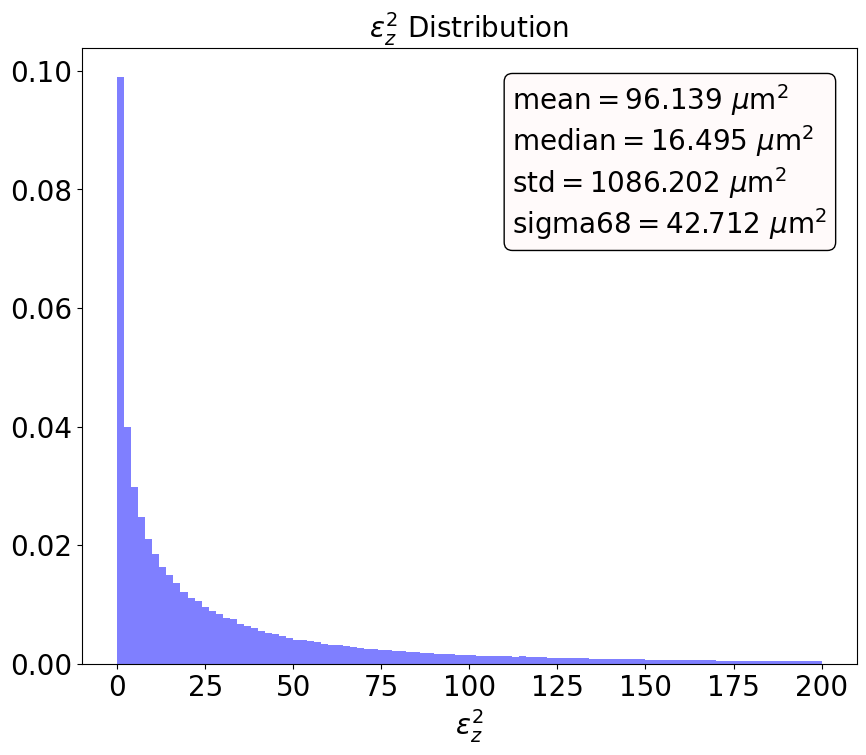

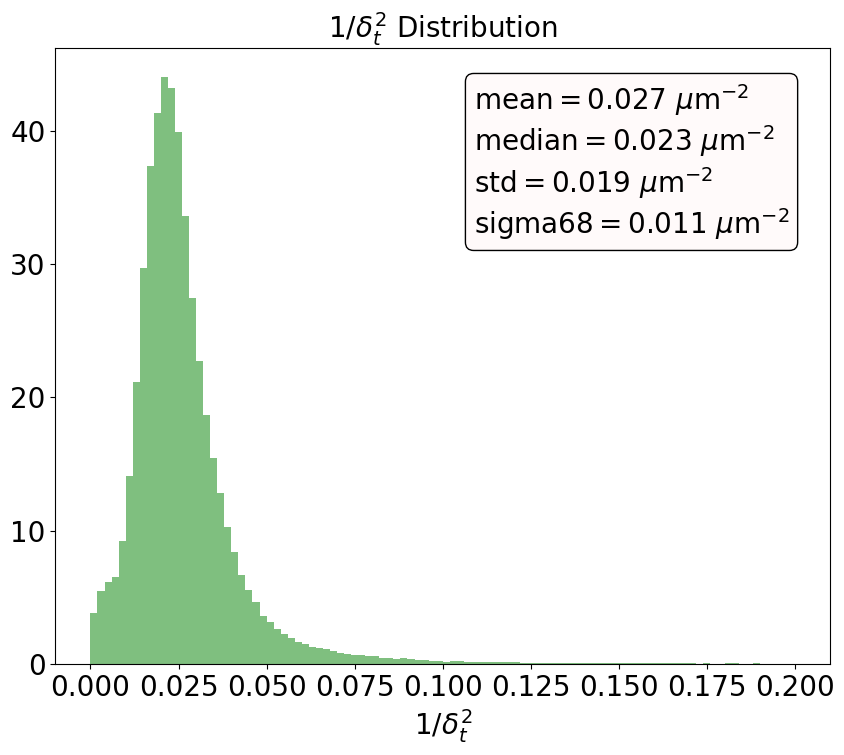

In [51]:
#trueClResFrac2
single_histo(df.trueClResFrac2, 100, 0, 4, r'$\frac{\varepsilon_z^2}{\delta_t^2}$ Distribution', r'$\frac{\varepsilon_z^2}{\delta_t^2}$',color='green',stat=False)

mean = df.trueClResFrac2.mean()
median = np.median(df.trueClResFrac2)
std = df.trueClResFrac2.std()
a = df.trueClResFrac2.quantile(1-0.16) 
b = df.trueClResFrac2.quantile(0.16)
q =(a-b)/2
    
textstr = '\n'.join((
             r'$\mathrm{mean}=%.3f$' % (mean, ),
             r'$\mathrm{median}=%.3f$' % (median, ),
             r'$\mathrm{std}=%.3f$' % (std, ),
             r'$\mathrm{sigma68}=%.3f$' % (q, )))
props = dict(boxstyle='round', facecolor='snow')
plt.text(0.52, 0.95, textstr, transform=ax.transAxes, fontsize=20, verticalalignment='top', bbox=props)

#trueClRes2
single_histo(df.trueClRes2, 100, 0, 200, r'$\varepsilon_z^2$ Distribution', r'$\varepsilon_z^2$',color='blue',stat=False)

mean = df.trueClRes2.mean()
median = np.median(df.trueClRes2)
std = df.trueClRes2.std()
a = df.trueClRes2.quantile(1-0.16) 
b = df.trueClRes2.quantile(0.16)
q =(a-b)/2
    
textstr2 = '\n'.join((
             r'$\mathrm{mean}=%.3f\ \mu$m$^2$' % (mean, ),
             r'$\mathrm{median}=%.3f\ \mu$m$^2$' % (median, ),
             r'$\mathrm{std}=%.3f\ \mu$m$^2$' % (std, ),
             r'$\mathrm{sigma68}=%.3f\ \mu$m$^2$' % (q, )))
props2 = dict(boxstyle='round', facecolor='snow')
plt.text(0.5, 0.95, textstr2, transform=ax.transAxes, fontsize=20, verticalalignment='top', bbox=props2)



#overTrkPosErr2
single_histo(df.overTrkPosErr2, 100, 0, 0.2, r'$1/\delta_t^2$ Distribution', r'$1/\delta_t^2$',color='green',stat=False)

mean = df.overTrkPosErr2.mean()
median = np.median(df.overTrkPosErr2)
std = df.overTrkPosErr2.std()
a = df.overTrkPosErr2.quantile(1-0.16) 
b = df.overTrkPosErr2.quantile(0.16)
q =(a-b)/2
    
textstr3 = '\n'.join((
             r'$\mathrm{mean}=%.3f\ \mu$m$^{-2}$' % (mean, ),
             r'$\mathrm{median}=%.3f\ \mu$m$^{-2}$' % (median, ),
             r'$\mathrm{std}=%.3f\ \mu$m$^{-2}$' % (std, ),
             r'$\mathrm{sigma68}=%.3f\ \mu$m$^{-2}$' % (q, )))
props3 = dict(boxstyle='round', facecolor='snow')
plt.text(0.45, 0.95, textstr3, transform=ax.transAxes, fontsize=20, verticalalignment='top', bbox=props3)

$\mathrm{mean}=0.027\ \mu$m
$\mathrm{median}=0.023\ \mu$m
$\mathrm{std}=0.02\ \mu$m
$\mathrm{sigma68}=0.01\ \mu$m
MPV = 0.02


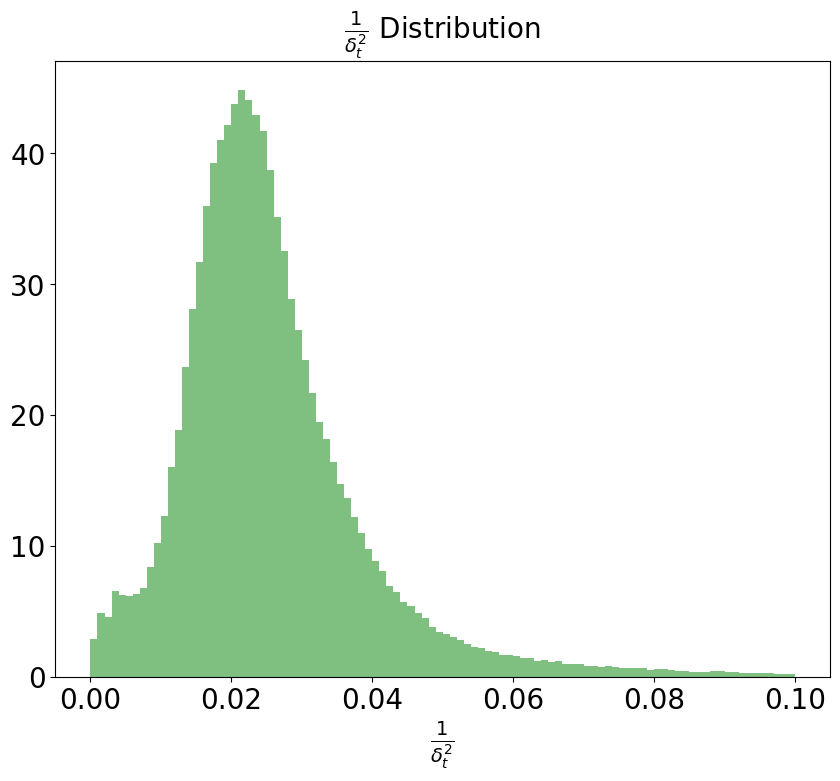

In [52]:
single_histo(df.overterr2, 100, 0, 0.1, r'$\frac{1}{\delta_t^2}$ Distribution', r'$\frac{1}{\delta_t^2}$',color='green',stat=False)

$\mathrm{mean}=0.046\ \mu$m
$\mathrm{median}=0.039\ \mu$m
$\mathrm{std}=2.24\ \mu$m
$\mathrm{sigma68}=1.60\ \mu$m


Text(0.72, 0.95, '$\\mathrm{mean}=0.046$\n$\\mathrm{median}=0.039$\n$\\mathrm{std}=2.244$\n$\\mathrm{sigma68}=1.601$')

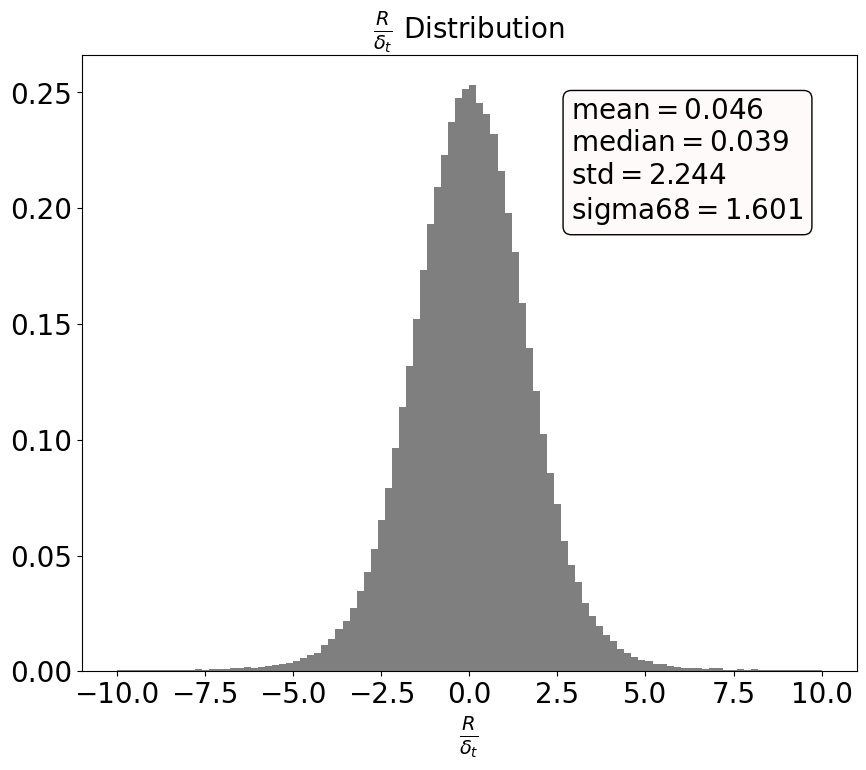

In [23]:
single_histo(df.Roverterr2, 100, -10, 10, r'$\frac{R}{\delta_t}$ Distribution', r'$\frac{R}{\delta_t}$',color='black',stat=False)

mean = df.Roverterr2.mean()
median = np.median(df.Roverterr2)
std = df.Roverterr2.std()
a = df.Roverterr2.quantile(1-0.16) 
b = df.Roverterr2.quantile(0.16)
q =(a-b)/2
    
textstr = '\n'.join((
             r'$\mathrm{mean}=%.3f$' % (mean, ),
             r'$\mathrm{median}=%.3f$' % (median, ),
             r'$\mathrm{std}=%.3f$' % (std, ),
             r'$\mathrm{sigma68}=%.3f$' % (q, )))
props = dict(boxstyle='round', facecolor='snow', alpha=1)
plt.text(0.72, 0.95, textstr, transform=ax.transAxes, fontsize=20, verticalalignment='top', bbox=props)